In [11]:
# Cell 1: Imports & Setup

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import os
import joblib
import numpy as np
from datetime import datetime

# Plotting style
#plt.style.use('seaborn-whitegrid')
SAVE_DIR = "Saved_files_new"


In [12]:
# Cell 2: Robust Data Loading

def try_read_csv(file_path, sep_choices=(';', ',')):
    """Try to read CSV with different separators for robustness."""
    for sep in sep_choices:
        try:
            df = pd.read_csv(file_path, sep=sep, encoding='utf-8')
            # If only 1 column and many commas left, probably wrong sep, try next
            if len(df.columns) == 1 and ',' in df.columns[0]:
                continue
            return df
        except Exception:
            continue
    raise ValueError(f"Could not load {file_path} with any separator.")

def load_complete_analysis_data(date_string, save_dir="Saved_files_new"):
    """Load all analysis data from the new pipeline (topics, methods, DataFrame, etc)."""
    print(f"Loading complete analysis data for {date_string}...")

    try:
        # --- Load analyzed DataFrame ---
        for base in [
            f"semantic_scholar_{date_string}_all_results.csv",
            f"semantic_scholar_{date_string}_enhanced_analysis.csv",
            f"semantic_scholar_{date_string}_results.csv"
        ]:
            df_filename = os.path.join(save_dir, base)
            if os.path.exists(df_filename):
                break
        else:
            raise FileNotFoundError("No analyzed CSV file found.")

        df_analyzed = try_read_csv(df_filename)

        # --- Load topic names and topic keywords ---
        topic_keywords = topic_names = None
        topic_json_filename = os.path.join(save_dir, f"topics_{date_string}.json")
        if os.path.exists(topic_json_filename):
            with open(topic_json_filename, 'r', encoding='utf-8') as f:
                topic_meta = json.load(f)
                topic_keywords = topic_meta['topics']
                topic_names = topic_meta.get('topic_names', None)
        # If separate files exist, use them
        if not topic_names:
            for nm in [
                f"topic_names_{date_string}.json",
                f"semantic_scholar_{date_string}_topic_names.json"
            ]:
                nm_path = os.path.join(save_dir, nm)
                if os.path.exists(nm_path):
                    with open(nm_path, 'r', encoding='utf-8') as f:
                        topic_names = json.load(f)
                    break

        print(f"Successfully loaded DataFrame (n={len(df_analyzed)}) and topic meta.")
        return {
            'df_analyzed': df_analyzed,
            'topic_names': topic_names,
            'topic_keywords': topic_keywords
        }
    except Exception as e:
        print(f"Error loading data: {e}")
        return None


In [19]:
# Cell 3: Topic Visualization Functions

def get_topic_name(topic_idx, topic_names):
    if not topic_names:
        return f"Topic {topic_idx}"
    return topic_names.get(str(topic_idx), f"Topic {topic_idx}")

def plot_topic_keywords_with_names(topic_keywords, topic_names, top_words=10):
    num_topics = len(topic_keywords)
    populated_topics = [k for k,v in topic_keywords.items() if 'word_weights' in v and len(v['word_weights']) > 0]
    if len(populated_topics) == 0:
        print("No non-empty topics found for plotting keywords.")
        return
    fig, axes = plt.subplots(len(populated_topics), 1, figsize=(14, 4*len(populated_topics)), squeeze=False)
    axes = axes.flatten()
    for plot_idx, topic_idx in enumerate(populated_topics):
        keywords = topic_keywords[topic_idx]
        words, weights = zip(*keywords['word_weights'][:top_words])
        ax = axes[plot_idx]
        bars = ax.barh(words, weights, color='steelblue', alpha=0.7)
        topic_name = get_topic_name(topic_idx, topic_names)
        ax.set_title(f'Topic {topic_idx}: {topic_name}', fontsize=14, fontweight='bold')
        ax.set_xlabel('Word Weight', fontsize=12)
        ax.invert_yaxis()
        for bar, weight in zip(bars, weights):
            ax.text(weight + 0.001, bar.get_y() + bar.get_height()/2, f'{weight:.3f}', va='center', fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_topic_importance_with_names(df, topic_names):
    if 'Primary_Topic' not in df.columns:
        print("No 'Primary_Topic' column in input DataFrame!")
        return
    topic_counts = df['Primary_Topic'].value_counts()
    plt.figure(figsize=(12, 8))
    bars = plt.bar(range(len(topic_counts)), topic_counts.values, color='lightcoral', alpha=0.7)
    plt.xticks(range(len(topic_counts)), [get_topic_name(t, topic_names) for t in topic_counts.index],
               rotation=45, ha='right')
    plt.title('Topic Importance (Number of Papers per Topic)', fontsize=16, fontweight='bold')
    plt.xlabel('Topics', fontsize=12)
    plt.ylabel('Number of Papers', fontsize=12)
    for bar, count in zip(bars, topic_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 str(count), ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_topic_trends_over_time(df, topic_col='Primary_Topic', year_col='year', top_n=10):
    topic_year = df.groupby([year_col, topic_col]).size().reset_index(name='count')
    top_topics = topic_year.groupby(topic_col)['count'].sum().nlargest(top_n).index
    topic_year = topic_year[topic_year[topic_col].isin(top_topics)]
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=topic_year, x=year_col, y='count', hue=topic_col, marker='o')
    plt.title('Topic Trends Over Time')
    plt.ylabel('Number of Papers')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [ ]:
# Cell 4: Method Visualization Functions

def plot_method_importance(df, method_col='Primary_Method', min_count=2, include_low_conf=False):
    conf_col = 'Method_Confidence' if 'Method_Confidence' in df.columns else None
    if include_low_conf or not conf_col:
        df_use = df
    else:
        df_use = df[~df[conf_col].str.lower().eq('low_confidence')]
    method_counts = df_use[method_col].value_counts().sort_values(ascending=False)
    method_counts = method_counts[method_counts >= min_count]
    plt.figure(figsize=(12, 8))
    bars = plt.bar(method_counts.index, method_counts.values, color='mediumseagreen', alpha=0.7)
    plt.xticks(range(len(method_counts)), method_counts.index, rotation=45, ha='right', fontsize=12)
    plt.ylabel('Number of Papers')
    plt.title('Method Importance (Papers per Method)')
    for bar, count in zip(bars, method_counts.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                 str(count), ha='center', va='bottom', fontsize=10)
    plt.tight_layout()
    plt.show()

def plot_method_trends_over_time(
    df, method_col='Primary_Method', year_col='year',
    top_n=8, include_low_conf=False, min_count=2, min_papers_per_year=20, window_smooth=1
):
    conf_col = 'Method_Confidence' if 'Method_Confidence' in df.columns else None
    if include_low_conf or not conf_col:
        df_use = df
    else:
        df_use = df[~df[conf_col].str.lower().eq('low_confidence')]
    value_counts = df_use[method_col].value_counts()
    top_methods = value_counts[value_counts >= min_count].index[:top_n]
    df_use = df_use[df_use[method_col].isin(top_methods)]
    if df_use.empty:
        print("No method assignment to plot.")
        return
    year_method_counts = df_use.groupby([year_col, method_col]).size().reset_index(name='count')
    year_totals = df.groupby(year_col).size().reset_index(name='total_count')
    # Only keep years with min_papers_per_year or more
    year_totals = year_totals[year_totals['total_count'] >= min_papers_per_year]
    merged = pd.merge(year_method_counts, year_totals, on=year_col)
    merged['fraction'] = merged['count'] / merged['total_count']
    # Optionally smooth
    if window_smooth > 1:
        merged = merged.sort_values([method_col, year_col])
        merged['fraction'] = merged.groupby(method_col)['fraction'].transform(lambda x: x.rolling(window_smooth, min_periods=1).mean())
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=merged, x=year_col, y='fraction', hue=method_col, marker='o')
    plt.title('Method Usage Fraction Over Time')
    plt.ylabel('Fraction of Papers Using Method')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    return merged



In [15]:
# Cell 5: Topic-Method Correlation Visualization

def plot_topic_method_heatmap(df, topic_col='Primary_Topic', method_col='Primary_Method',
                             top_n_methods=8, top_n_topics=8, include_low_conf=False):
    conf_col = 'Method_Confidence' if 'Method_Confidence' in df.columns else None
    if include_low_conf or not conf_col:
        df_use = df
    else:
        df_use = df[~df[conf_col].str.lower().eq('low_confidence')]
    top_methods = df_use[method_col].value_counts().head(top_n_methods).index
    top_topics = df_use[topic_col].value_counts().head(top_n_topics).index
    df_corr = df_use[df_use[method_col].isin(top_methods) & df_use[topic_col].isin(top_topics)]
    if df_corr.empty:
        print("No sufficient data for topic-method correlation heatmap.")
        return
    pivot = df_corr.pivot_table(index=topic_col, columns=method_col, aggfunc='size', fill_value=0)
    plt.figure(figsize=(2+2*len(top_methods), 2+2*len(top_topics)))
    sns.heatmap(pivot, annot=True, cmap='viridis', fmt='d')
    plt.title("Topic-Method Co-Occurrence (Count)")
    plt.ylabel("Topic")
    plt.xlabel("Method")
    plt.tight_layout()
    plt.show()


In [18]:
# Cell 6: Complete Visualization Suite

def create_complete_visualization_suite(
    df_analyzed,
    topic_names=None,
    topic_keywords=None,
    file_prefix=None,
    output_dir=None,
    include_low_conf=False,
    min_method_count=2
):
    print("=== COMPLETE VISUALIZATION SUITE ===")
    # 1. Topic Visualizations
    if topic_names and topic_keywords:
        print("1. Topic Analysis Visualizations:")
        plot_topic_keywords_with_names(topic_keywords, topic_names)
        plot_topic_importance_with_names(df_analyzed, topic_names)
        if 'year' in df_analyzed.columns:
            plot_topic_trends_over_time(df_analyzed, year_col='year')
    # 2. Method Visualizations
    if 'Primary_Method' in df_analyzed.columns:
        print("2. Method Analysis Visualizations:")
        plot_method_importance(df_analyzed, min_count=min_method_count, include_low_conf=include_low_conf)
        if 'year' in df_analyzed.columns:
            plot_method_trends_over_time(df_analyzed, min_papers_per_year=25, window_smooth=3)
    # 3. Method-Topic Correlation
    print("3. Topic-Method Correlation Heatmap:")
    plot_topic_method_heatmap(
        df_analyzed, top_n_methods=8, top_n_topics=8, include_low_conf=include_low_conf
    )
    print("\n✓ Visualization suite completed.\n")


Loading complete analysis data for 2025_08_20reliability_resilience_power_systems...
Successfully loaded DataFrame (n=28934) and topic meta.
=== COMPLETE VISUALIZATION SUITE ===
1. Topic Analysis Visualizations:
No non-empty topics found for plotting keywords.


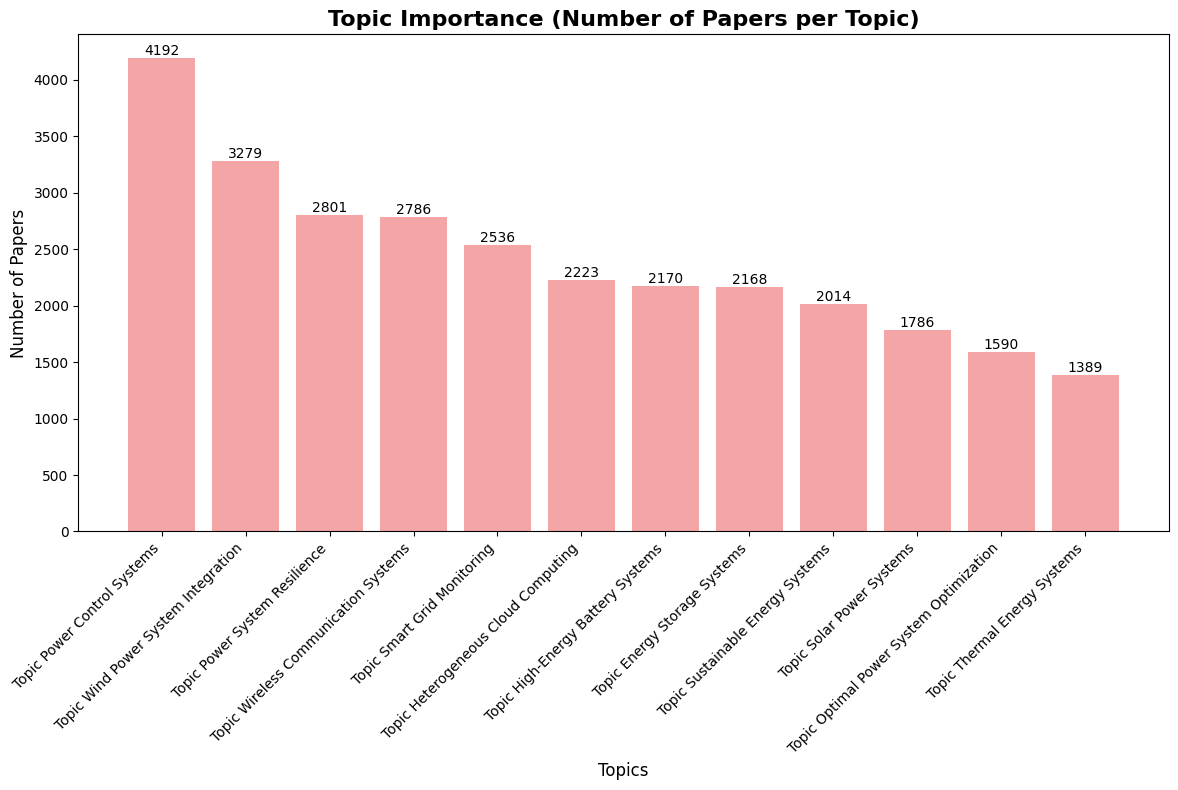

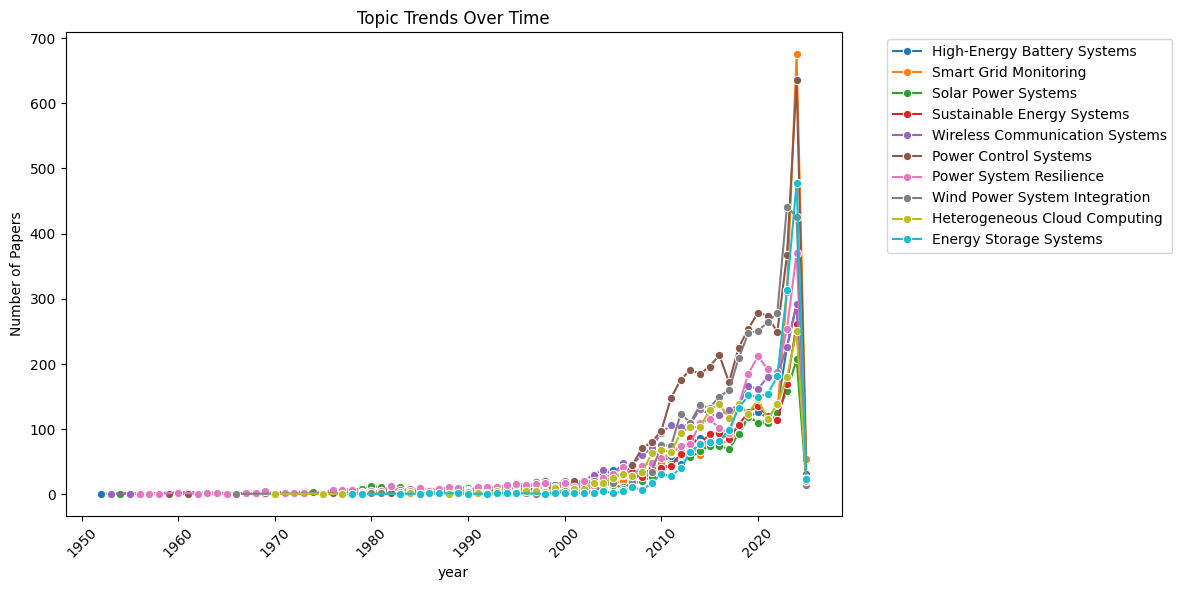

2. Method Analysis Visualizations:


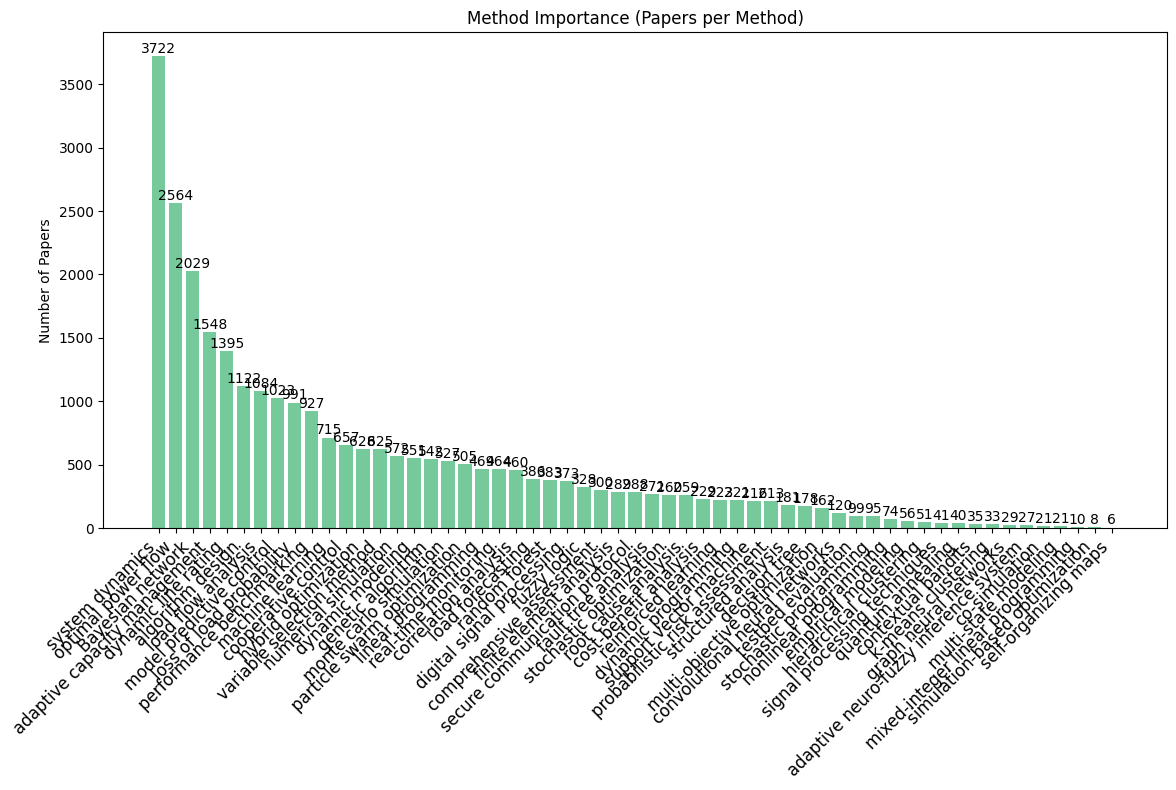

TypeError: plot_method_trends_over_time() got an unexpected keyword argument 'min_papers_per_year'

In [20]:
# Cell 7: Run Analysis and Visualization

# Set to match your analysis output's date string:
date_string = "2025_08_20reliability_resilience_power_systems"

analysis_data = load_complete_analysis_data(date_string)
if analysis_data:
    create_complete_visualization_suite(
        df_analyzed=analysis_data['df_analyzed'],
        topic_names=analysis_data['topic_names'],
        topic_keywords=analysis_data['topic_keywords'],
        file_prefix=f"semantic_scholar_{date_string}",
        output_dir=os.path.join(SAVE_DIR, f"visualizations_{date_string}"),
        include_low_conf=False,  # Set True if you want to include low-confidence
        min_method_count=2,
    )
